In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as GS
from scipy import stats

### Analysing the Results for the shift

In this tutorial we analyse our results to see how good the predictions are and what are potential problems are.
For that we will visualize the results in different ways.

Here we concentrate on analysing the effect of the shift. First we define our parameters again, that is the range of shifts, the direction, frame rate and the path to the file

In [2]:
shifts = list(range(-25,25,2))+[0]
direction = [True, False]
# Frame rate
fps = 500

keytemplate = '/forward_{}/temporal_{}'
filename_best = 'chapter_4_results/Best/feed_forward_results_bee17_blk1_all_40.h5'

Then we make a summery including correlations for a better overview

In [3]:
summary = pd.DataFrame(index=pd.MultiIndex.from_product([shifts, direction]),
                       columns = pd.MultiIndex.from_product([['error_angle','pred_norm'],
                                ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]))
allresults = dict()
summary.index.names = ['shifts','directions']
for index, _ in summary.iterrows():
    shift, direct = index
    shift = None if shift==0 else int(shift)
    # Load results
    results = pd.read_hdf(filename_best, key = keytemplate.format(direct, shift))
    sumry = results.error_angle.describe()
    summary.loc[index,'error_angle'] = sumry.values
    sumry = results.pred_norm.describe()
    summary.loc[index,'pred_norm'] = sumry.values
    spearcorr = results[['test_target',0]].corr(method='pearson')
    spearcorr = spearcorr.values[0,1]
    # if the correlation is nan, that means we have a std of zero and therefore a prediction was not possible
    if np.isnan(spearcorr):
        spearcorr = 0
    summary.loc[index,'spearman']=spearcorr 
    results.loc[:,'spearman']=spearcorr
    allresults[index] = results.copy()

In [4]:
summary.head()

error_angle                                              \
                        count      mean       std          min        25%   
shifts directions                                                           
-25    True              3361  0.361008  0.282134   0.00209145   0.139061   
       False             3404  0.403144  0.548202    0.0123125  0.0587793   
-23    True              3347  0.347837  0.280158  0.000235553   0.130177   
       False             3414  0.401819  0.547805   0.00988751   0.058054   
-21    True              3358  0.319504  0.262316   0.00219243   0.116191   

                                               pred_norm            \
                        50%       75%      max     count      mean   
shifts directions                                                    
-25    True        0.287036  0.535672  1.47101      3388  0.999975   
       False       0.136307  0.487631  2.37243      3404  0.999939   
-23    True        0.275854  0.495414  1.50131      3394  0.999976   
       False       0.136256  0.484251  2.37325      3414  0.999939   
-21    True        0.248018  0.472302  1.51163      3392  0.999977   

                                                                        \
                           std       min       25%       50%       75%   
shifts directions                                                        
-25    True        1.27755e-05  0.999964  0.999967  0.999972  0.999977   
       False                 0  0.999939  0.999939  0.999939  0.999939   
-23    True        1.17226e-05  0.999963  0.999967  0.999974  0.999981   
       False                 0  0.999939  0.999939  0.999939  0.999939   
-21    True        1.32361e-05  0.999962  0.999966  0.999975  0.999983   

                             spearman  
                        max            
shifts directions                      
-25    True         1.00004  0.490272  
       False       0.999939  0.000000  
-23    True         1.00004  0.541237  
       False       0.999939  0.000000  
-21    True         1.00004  0.599082

concatinate the results for every shift

In [5]:
allresults = pd.concat(allresults)
allresults.index.names = ['shift','direction','beeid','blk_i','frame_i']

show the summary

In [6]:
allresults.head()

0  pred_norm  error_angle  \
shift direction beeid blk_i frame_i                                     
-25   True      17    0     353.0   -0.003495   0.999970     0.178715   
                            354.0   -0.003515   0.999970     0.179958   
                            355.0   -0.003446   0.999970     0.194903   
                            356.0   -0.003303   0.999970     0.220755   
                            357.0   -0.003298   0.999969     0.241234   

                                     window_size  units  test_target  \
shift direction beeid blk_i frame_i                                    
-25   True      17    0     353.0             33     64    -0.006624   
                            354.0             33     64    -0.006648   
                            355.0             33     64    -0.006842   
                            356.0             33     64    -0.007149   
                            357.0             33     64    -0.007512   

                                     test_target_error shift  ws  \
shift direction beeid blk_i frame_i                                
-25   True      17    0     353.0             0.007382   -25  33   
                            354.0             0.004402   -25  33   
                            355.0             0.005464   -25  33   
                            356.0             0.004955   -25  33   
                            357.0             0.004846   -25  33   

                                     test_observations  spearman  
shift direction beeid blk_i frame_i                               
-25   True      17    0     353.0            -0.007467  0.490272  
                            354.0            -0.007835  0.490272  
                            355.0            -0.007961  0.490272  
                            356.0            -0.007924  0.490272  
                            357.0            -0.007821  0.490272

## Explaining the shift

Before we plot the data for analyses, we will explain the shift a bit better since our main focus is the influence of the temporal shift of the observation on the results. Basically the shift indicates how much the observation is shiftet forward or backward in time before it is fed into the classifier. For an example we will use body to head prediction and a shift of 21 with a window size of 21

In [7]:
ws = 21
deltat = 11

Then we load the data for demonstration

In [8]:
results = pd.read_hdf(filename_best, key = keytemplate.format(direction[1], None))
results.head()

0  pred_norm  error_angle  window_size  units  \
beeid blk_i frame_i                                                         
17    0     351.0   -0.011667   0.999996     0.316297           29     32   
            352.0   -0.011932   0.999999     0.289559           29     32   
            353.0   -0.011762   0.999997     0.245715           29     32   
            354.0   -0.011194   0.999991     0.192314           29     32   
            355.0   -0.010279   0.999982     0.132393           29     32   

                     test_target  test_target_error shift  ws  \
beeid blk_i frame_i                                             
17    0     351.0      -0.006148           0.006799   NaN  29   
            352.0      -0.006875           0.008411   NaN  29   
            353.0      -0.007467           0.007370   NaN  29   
            354.0      -0.007835           0.004405   NaN  29   
            355.0      -0.007961           0.005469   NaN  29   

                     test_observations  
beeid blk_i frame_i                     
17    0     351.0            -0.008907  
            352.0            -0.009683  
            353.0            -0.010262  
            354.0            -0.010567  
            355.0            -0.010598

and plot part of it

Text(0.5, 1.0, 'Forcasting | $\\Delta t<0$')

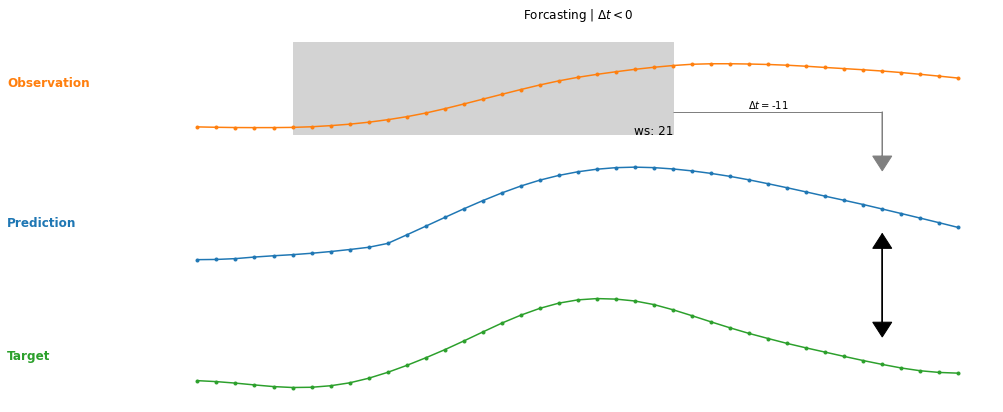

In [9]:
# Add sketch

# Define range for sketch
results = results.xs('17',level='beeid').xs(0,level='blk_i')

idx_sketch = np.arange(1534,1575)
fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(111)

midpoint = idx_sketch[idx_sketch.shape[0]//2]-5
ax.fill_between([midpoint-ws//2,midpoint+ws//2],1550,2800, color='lightgray',alpha=1)
ax.plot(fps*np.rad2deg(results.loc[idx_sketch,0]),label='prediction', marker='.')
ax.plot(1800+fps*np.rad2deg(results.loc[idx_sketch,'test_observations']),label='observation', marker='.')
ax.plot(-1800+fps*np.rad2deg(results.loc[idx_sketch,'test_target']),label='target', marker='.')
predpoint = midpoint + ws//2 + deltat
ax.arrow(midpoint + ws//2,1850, deltat, 0,
         head_length=0,head_width=0, ec='gray', fc='gray')
ax.arrow(midpoint + ws//2+deltat,1850, 0, -600,
         head_length=200,head_width=1, ec='gray', fc='gray')
ax.text(midpoint + ws//2+deltat//2,1900,'$\Delta t=$'+'-{}'.format(deltat),horizontalalignment='center')
ax.arrow(midpoint + ws//2+deltat,200, 0, -1200,head_length=200,head_width=1, ec='k', fc='k')
ax.arrow(midpoint + ws//2+deltat,-1000, 0, 1000,head_length=200,head_width=1, ec='k', fc='k')
ax.text(midpoint+ws//2,1550,'ws: 21', color='k', fontsize='large', horizontalalignment='right')
ax.text(np.min(idx_sketch)-10,2200,'Observation', color='C1', fontsize='large', fontweight='bold')
ax.text(np.min(idx_sketch)-10,300,'Prediction', color='C0', fontsize='large', fontweight='bold')
ax.text(np.min(idx_sketch)-10,-1500,'Target', color='C2', fontsize='large', fontweight='bold')
ax.axis('off')
ax.set_title('Forcasting | $\Delta t<0$')



Here the plottet data is without a shift, the gray box indicates a window of 21. Now if we use a shift of 11 the observation would be shifted 11 miliseconds to the right, so that the obervations in the gray box move to the right where the arrow points at. A temporal shift would represent a delay (smaller) a delay in the body motion compared to the head.

The same can be done when prediting body orientation from head. Just that in that case, the shift is into the other direction and delay is bigger???

Text(0.5, 1.0, 'Backcasting $\\Delta t>0$')

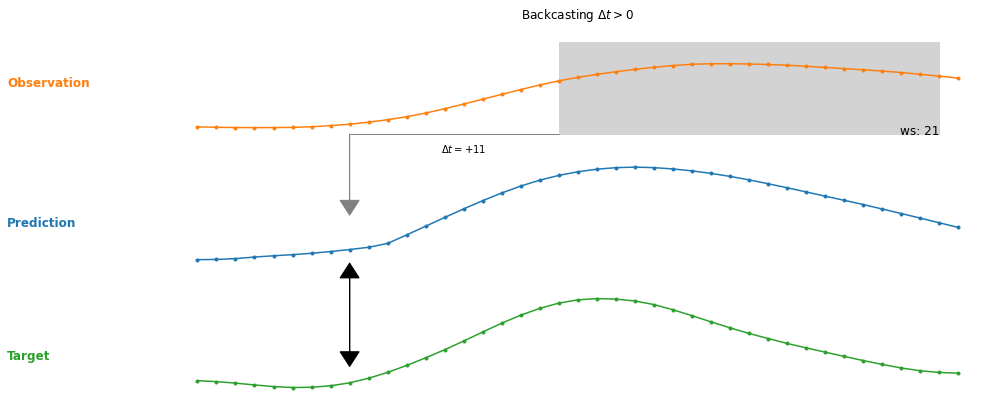

In [10]:
idx_sketch = np.arange(1534,1575)
fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(111)

ws = 21
deltat = 11
midpoint = idx_sketch[idx_sketch.shape[0]//2]+9
ax.fill_between([midpoint-ws//2,midpoint+ws//2],1550,2800, color='lightgray',alpha=1)
ax.plot(fps*np.rad2deg(results.loc[idx_sketch,0]),label='prediction', marker='.')
ax.plot(1800+fps*np.rad2deg(results.loc[idx_sketch,'test_observations']),label='observation', marker='.')
ax.plot(-1800+fps*np.rad2deg(results.loc[idx_sketch,'test_target']),label='target', marker='.')
predpoint = midpoint - ws//2 - deltat
ax.arrow(midpoint - ws//2,1550, -deltat, 0,
         head_length=0,head_width=0, ec='gray', fc='gray')
ax.arrow(midpoint - ws//2-deltat,1550, 0, -900,
         head_length=200,head_width=1, ec='gray', fc='gray')
ax.text(midpoint - ws//2-deltat//2,1305,'$\Delta t=$'+'+{}'.format(deltat),horizontalalignment='center')
ax.arrow(midpoint - ws//2-deltat,-200, 0, -1200,head_length=200,head_width=1, ec='k', fc='k')
ax.arrow(midpoint - ws//2-deltat,-1400, 0, 1000,head_length=200,head_width=1, ec='k', fc='k')
ax.text(midpoint+ws//2,1550,'ws: 21', color='k', fontsize='large', horizontalalignment='right')
ax.text(np.min(idx_sketch)-10,2200,'Observation', color='C1', fontsize='large', fontweight='bold')
ax.text(np.min(idx_sketch)-10,300,'Prediction', color='C0', fontsize='large', fontweight='bold')
ax.text(np.min(idx_sketch)-10,-1500,'Target', color='C2', fontsize='large', fontweight='bold')
ax.axis('off')
ax.set_title('Backcasting $\Delta t>0$')

### Analysing the error in dependence of the shift

Then we plot the error of the per shift for thorax to head. Note that we report the shift in $\Delta t$ [ms]

Text(0.5, 0, 'Time [s]')

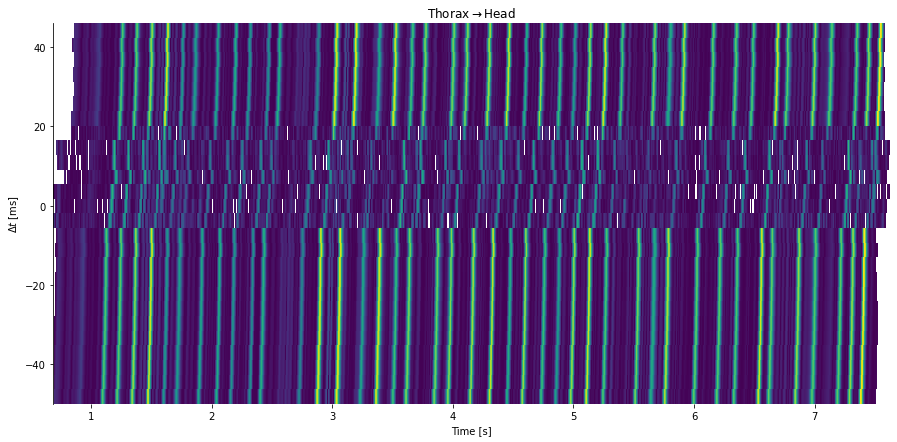

In [11]:
vmin = fps*allresults.error_angle.min()
vmax = fps*allresults.error_angle.max()

fig = plt.figure(figsize=(15,7))
ax=fig.add_subplot(111)
# Head to body
toplot = fps*allresults.error_angle.xs(False,level='direction').xs('17',level='beeid').xs(0,level='blk_i')
toplot = toplot.unstack()
toplot = toplot[::-1]
ax.imshow(toplot, interpolation='nearest', aspect='auto',vmin=vmin,vmax=vmax,
          extent=[toplot.columns.min()/fps,toplot.columns.max()/fps,
                  1000*toplot.index.min()/fps,1000*toplot.index.max()/fps])
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$\Delta t$ [ms]')
ax.set_title(r'Thorax$\rightarrow$Head')
ax.set_xlabel('Time [s]')



Now that does not tell us much if we do not know what happens at the same time in the original data, so we plot both in the same figure

Text(0, 0.5, 'Angular velocity [$\\circ$/s]')

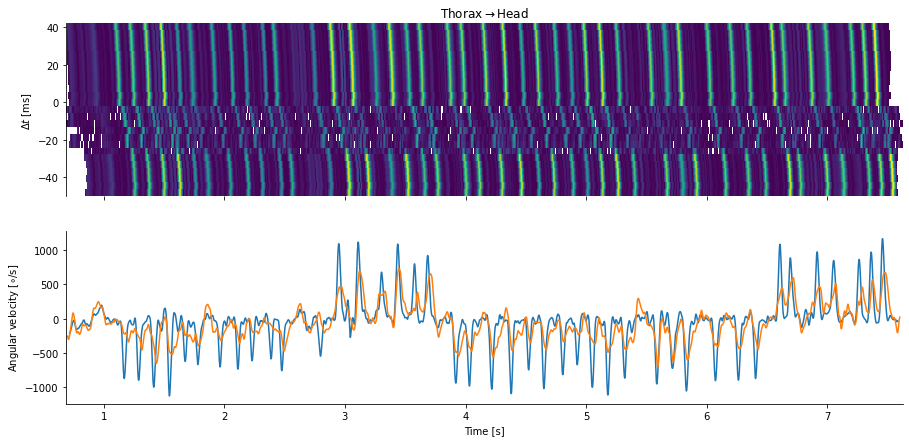

In [12]:
vmin = fps*allresults.error_angle.min()
vmax = fps*allresults.error_angle.max()

fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize = (15, 7))
ax=ax1

# Head to body
toplot = fps*allresults.error_angle.xs(False,level='direction').xs('17',level='beeid').xs(0,level='blk_i')
toplot = toplot.unstack()
toplot = toplot[:-1]
ax.imshow(toplot, interpolation='nearest', aspect='auto',vmin=vmin,vmax=vmax,
          extent=[toplot.columns.min()/fps,toplot.columns.max()/fps,
                  1000*toplot.index.min()/fps,1000*toplot.index.max()/fps])
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$\Delta t$ [ms]')
ax.set_title(r'Thorax$\rightarrow$Head')

ax= ax2
head = fps*np.rad2deg(allresults.test_observations.xs(True,level='direction').xs('17',level='beeid').xs(0,level='blk_i'))
head = head.xs(0,level='shift')
body = fps*np.rad2deg(allresults.test_observations.xs(False,level='direction').xs('17',level='beeid').xs(0,level='blk_i'))
body = body.xs(0,level='shift')
ax.plot(head.index/fps,head.values)
ax.plot(body.index/fps,body.values)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Angular velocity [$\circ$/s]')

Now we can see, that the big errors occur when we have a saccade, especially when the head is making big saccades. Therefore using the median error as a indicator on how well our classifier works might not be so good, as there is a lot less saccades than than intersaccades time vice. Therefore it might be better to use the biggest error for validation.

Also we can see, that the error is small when the shift is between -10 and 0 and bigger for the other shifts.

Then we can check if its the same for the head to body orientation

Text(0, 0.5, 'Angular velocity [$\\circ$/s]')

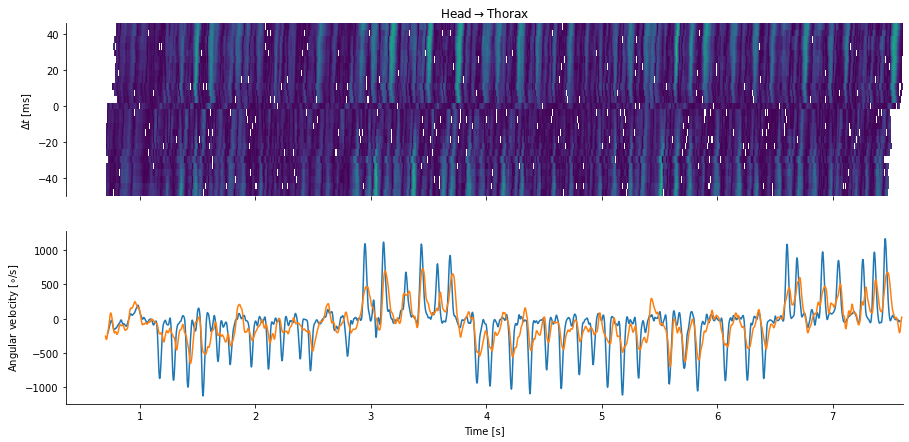

In [13]:
vmin = fps*allresults.error_angle.min()
vmax = fps*allresults.error_angle.max()

fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize = (15, 7))
ax=ax1

# Head to body
toplot = fps*allresults.error_angle.xs(True,level='direction').xs('17',level='beeid').xs(0,level='blk_i')
toplot = toplot.unstack()
toplot = toplot[::-1]
ax.imshow(toplot, interpolation='nearest', aspect='auto',vmin=vmin,vmax=vmax,
          extent=[toplot.columns.min()/fps,toplot.columns.max()/fps,
                  1000*toplot.index.min()/fps,1000*toplot.index.max()/fps])
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$\Delta t$ [ms]')
ax.set_title(r'Head$\rightarrow$Thorax')

ax= ax2
head = fps*np.rad2deg(allresults.test_observations.xs(True,level='direction').xs('17',level='beeid').xs(0,level='blk_i'))
head = head.xs(0,level='shift')
body = fps*np.rad2deg(allresults.test_observations.xs(False,level='direction').xs('17',level='beeid').xs(0,level='blk_i'))
body = body.xs(0,level='shift')
ax.plot(head.index/fps,head.values)
ax.plot(body.index/fps,body.values)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Angular velocity [$\circ$/s]')

Here we see, that we have a similar pattern but the errors are smaller as expected. Also here we see a window in the shift where the error is smaller than for other shift, but compared to the body to head prediction this window is with -1 to 0 much smaller. However we can see, that for positive shift from 0 to 11 the error is smaller than for the other shifts. This might indicate, that as heas saccades occur before body saccades, there is a delay of about 0 to 11 mili seconds of delay between the signal that arrives in the head and that that arrives in the body(with a positive shift we look into the past)

However, we can not say why this delay occurs, maybe its only due to the fact that the sensory input needs longer to travel from the eyes to the body than to the head  or maybe because the signal is passed from the head to the body and therefore needs to arrive at the head first. (maybe for the second possiblity it might be more logical, as there might be head saccades without body saccades???)

-note: Also head and body physical connected so if head moves, body will always move a bit ???







To see the shift of the signal better we will plot the max error angle for each shift. 

Text(0.5, 0, '$\\Delta t$ [ms]')

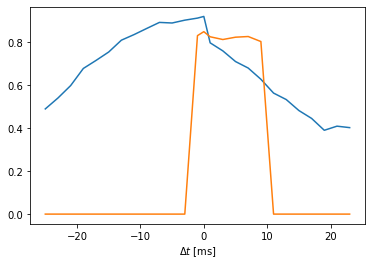

In [15]:
fig = plt.figure()
ax = fig.gca()
for direct, c in zip([True,False],['C0','C1']):
    toplot = pd.DataFrame(summary.spearman.xs(direct, level='directions').sort_index())
    toplot.spearman.plot(ax=ax, color=c)
ax.set_xlabel('$\Delta t$ [ms]')

Here we can see that there is a certain window of shifts, where the error is low for both head to body and body to head prediction. This might indicate, that a delay in the signal from head to body is tolerable as long as it is not too much delayed (here about 7 ms). We would expect a negative shift in the body as since the body seams to follow the head biological speaking. For the body to head prediction we would expact this positive shift, as we inverse the head to body prediction here.

### Summary

For a better overview, we can plot everything in the same figure now

<ipython-input-16-d8de8d06fcf1>:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


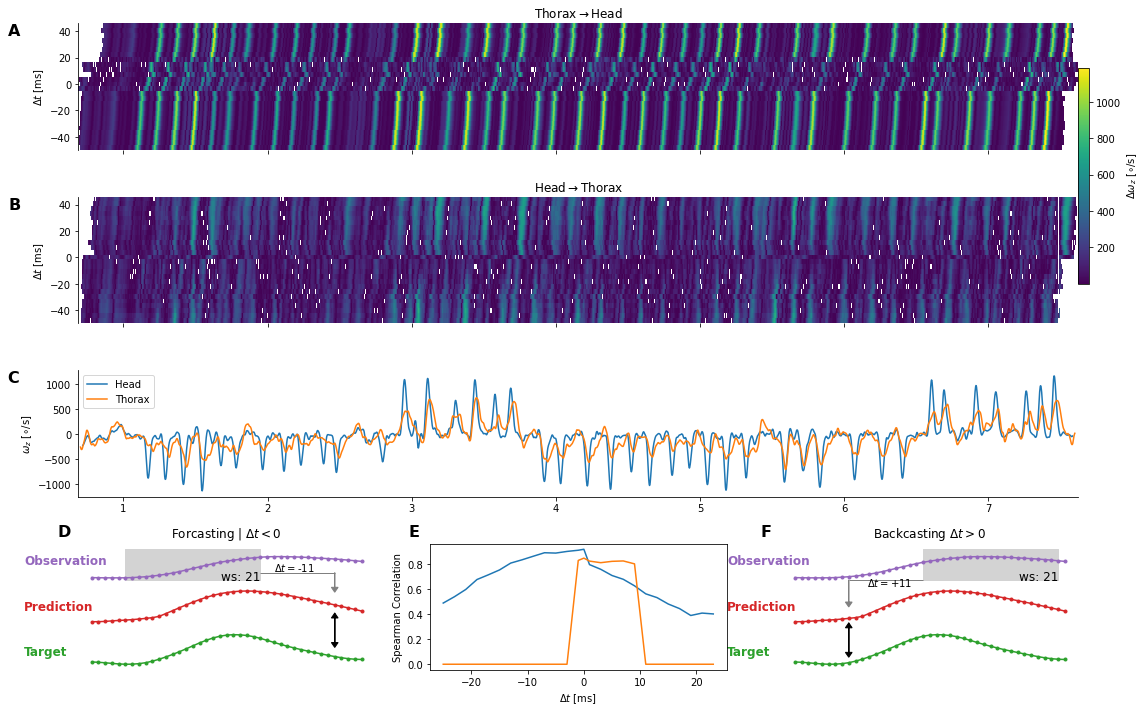

In [16]:
# Create a figure to show prediction
fig = plt.figure(figsize=(15,10))
axarr = dict()
gs = GS.GridSpec(4, 6)
axarr['timecourse'] = fig.add_subplot(gs[2,:])
axarr['bodyhead'] = fig.add_subplot(gs[0,:], sharex=axarr['timecourse'])
axarr['headbody'] = fig.add_subplot(gs[1,:], sharex=axarr['timecourse'])
axarr['sketch_pos'] = fig.add_subplot(gs[3,4:])
axarr['sketch_neg'] = fig.add_subplot(gs[3,:2])
axarr['shift'] = fig.add_subplot(gs[3,2:4])

vmin = fps*allresults.error_angle.min()
vmax = fps*allresults.error_angle.max()

ax=axarr['headbody']
# Head to body
toplot = fps*allresults.error_angle.xs(True,level='direction').xs('17',level='beeid').xs(0,level='blk_i')
toplot = toplot.unstack()
toplot = toplot[::-1]
im = ax.imshow(toplot, interpolation='nearest', aspect='auto',vmin=vmin,vmax=vmax,
          extent=[toplot.columns.min()/fps,toplot.columns.max()/fps,
                  1000*toplot.index.min()/fps,1000*toplot.index.max()/fps])
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$\Delta t$ [ms]')
ax.set_title(r'Head$\rightarrow$Thorax')

ax=axarr['bodyhead']
# Body to head
toplot = fps*allresults.error_angle.xs(False,level='direction').xs('17',level='beeid').xs(0,level='blk_i')
toplot = toplot.unstack()
toplot = toplot[::-1]
im = ax.imshow(toplot, interpolation='nearest', aspect='auto',vmin=vmin,vmax=vmax,
               extent=[toplot.columns.min()/fps,toplot.columns.max()/fps,
                  1000*toplot.index.min()/fps,1000*toplot.index.max()/fps])
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('$\Delta t$ [ms]')
ax.set_title(r'Thorax$\rightarrow$Head')


ax=axarr['timecourse'] 
head = fps*np.rad2deg(allresults.test_observations.xs(True,level='direction').xs('17',level='beeid').xs(0,level='blk_i'))
head = head.xs(0,level='shift')
body = fps*np.rad2deg(allresults.test_observations.xs(False,level='direction').xs('17',level='beeid').xs(0,level='blk_i'))
body = body.xs(0,level='shift')
ax.plot(head.index/fps,head.values, label='Head')
ax.plot(body.index/fps,body.values, label='Thorax')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_ylabel('$\omega_z$ [$\circ$/s]')

#Body to head
results = pd.read_hdf(filename_best, key = keytemplate.format(False, None))
results = results.xs('17',level='beeid').xs(0,level='blk_i')
# Add sketch
ax = axarr['sketch_neg']
ws = 21
deltat = 11
midpoint = idx_sketch[idx_sketch.shape[0]//2]-5
ax.fill_between([midpoint-ws//2,midpoint+ws//2],1550,2800, color='lightgray',alpha=1)
ax.plot(fps*np.rad2deg(results.loc[idx_sketch,0]),label='prediction', marker='.', color='C3')
ax.plot(1800+fps*np.rad2deg(results.loc[idx_sketch,'test_observations']),label='observation', marker='.', color='C4')
ax.plot(-1800+fps*np.rad2deg(results.loc[idx_sketch,'test_target']),label='target', marker='.', color='C2')
predpoint = midpoint + ws//2 + deltat
ax.arrow(midpoint + ws//2,1850, deltat, 0,
         head_length=0,head_width=0, ec='gray', fc='gray')
ax.arrow(midpoint + ws//2+deltat,1850, 0, -600,
         head_length=200,head_width=1, ec='gray', fc='gray')
ax.text(midpoint + ws//2+deltat//2,1900,'$\Delta t=$'+'-{}'.format(deltat),horizontalalignment='center')
ax.arrow(midpoint + ws//2+deltat,200, 0, -1200,head_length=200,head_width=1, ec='k', fc='k')
ax.arrow(midpoint + ws//2+deltat,-1000, 0, 1000,head_length=200,head_width=1, ec='k', fc='k')
ax.text(midpoint+ws//2,1550,'ws: 21', color='k', fontsize='large', horizontalalignment='right')
ax.text(np.min(idx_sketch)-10,2200,'Observation', color='C4', fontsize='large', fontweight='bold')
ax.text(np.min(idx_sketch)-10,300,'Prediction', color='C3', fontsize='large', fontweight='bold')
ax.text(np.min(idx_sketch)-10,-1500,'Target', color='C2', fontsize='large', fontweight='bold')
ax.axis('off')
ax.set_title('Forcasting | $\Delta t<0$')

# Add sketch
ax = axarr['sketch_pos']
ws = 21
deltat = 11
midpoint = idx_sketch[idx_sketch.shape[0]//2]+9
ax.fill_between([midpoint-ws//2,midpoint+ws//2],1550,2800, color='lightgray',alpha=1)
ax.plot(fps*np.rad2deg(results.loc[idx_sketch,0]),label='prediction', marker='.', color='C3')
ax.plot(1800+fps*np.rad2deg(results.loc[idx_sketch,'test_observations']),label='observation', marker='.', color='C4')
ax.plot(-1800+fps*np.rad2deg(results.loc[idx_sketch,'test_target']),label='target', marker='.', color='C2')
predpoint = midpoint - ws//2 - deltat
ax.arrow(midpoint - ws//2,1550, -deltat, 0,
         head_length=0,head_width=0, ec='gray', fc='gray')
ax.arrow(midpoint - ws//2-deltat,1550, 0, -900,
         head_length=200,head_width=1, ec='gray', fc='gray')
ax.text(midpoint - ws//2-deltat//2,1305,'$\Delta t=$'+'+{}'.format(deltat),horizontalalignment='center')
ax.arrow(midpoint - ws//2-deltat,-200, 0, -1200,head_length=200,head_width=1, ec='k', fc='k')
ax.arrow(midpoint - ws//2-deltat,-1400, 0, 1000,head_length=200,head_width=1, ec='k', fc='k')
ax.text(midpoint+ws//2,1550,'ws: 21', color='k', fontsize='large', horizontalalignment='right')
ax.text(np.min(idx_sketch)-10,2200,'Observation', color='C4', fontsize='large', fontweight='bold')
ax.text(np.min(idx_sketch)-10,300,'Prediction', color='C3', fontsize='large', fontweight='bold')
ax.text(np.min(idx_sketch)-10,-1500,'Target', color='C2', fontsize='large', fontweight='bold')
ax.axis('off')
ax.set_title('Backcasting $\Delta t>0$')

ax=axarr['shift']
for direct, c in zip([True,False],['C0','C1']):
    toplot = pd.DataFrame(summary.spearman.xs(direct, level='directions').sort_index())
    #toplot = toplot.astype(float)
    #toplot = 500*toplot
    #toplot = toplot.set_index(toplot.index.values/fps)
    toplot.spearman.plot(ax=ax, color=c)
ax.set_xlabel('$\Delta t$ [ms]')
ax.set_ylabel('Spearman Correlation')#('Max $\Delta \omega_z$ [$^\circ /s$]')


ax=axarr['timecourse'] 
ax.spines['bottom'].set_visible(True)
ax.tick_params(labelbottom=True,labeltop=False)
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time [s]') 
fig.tight_layout()
# Add colour bar
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.99, 0.6, 0.01, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\Delta \omega_z$ [$\circ$/s]')

# Add text
ax = axarr['timecourse']
ax.text(-0.071, 1.0, 'C', horizontalalignment='left',
        verticalalignment='top', transform=ax.transAxes, weight='bold', fontsize=16)
ax = axarr['bodyhead']
ax.text(-0.07, 1.0, 'A', horizontalalignment='left',
        verticalalignment='top', transform=ax.transAxes, weight='bold', fontsize=16)
ax = axarr['headbody']
ax.text(-0.07, 1.0, 'B', horizontalalignment='left',
        verticalalignment='top', transform=ax.transAxes, weight='bold', fontsize=16)
ax = axarr['sketch_neg']
ax.text(-0.07, 1.15, 'D', horizontalalignment='left',
        verticalalignment='top', transform=ax.transAxes, weight='bold', fontsize=16)
ax = axarr['shift']
ax.text(-0.07, 1.15, 'E', horizontalalignment='left',
        verticalalignment='top', transform=ax.transAxes, weight='bold', fontsize=16)
ax = axarr['sketch_pos']
ax.text(-0.07, 1.15, 'F', horizontalalignment='left',
        verticalalignment='top', transform=ax.transAxes, weight='bold', fontsize=16)

plt.tight_layout()
fig.savefig('chapter_4_results/chap_04f_HeadThoraxForecasting.svg', bbox_inches = "tight")
fig.savefig('chapter_4_results/chap_04f_HeadThoraxForecasting.png',  bbox_inches = "tight")